In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import glob
import os
from skimage.metrics import structural_similarity
import csv

In [81]:
def display(img, cmap = None):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap)

In [82]:
# Specify the directory where the images are located
folder = "2024-06"
image_dir = f"data/{folder}"

# Get a list of all image files in the directory and its subdirectories
image_files = glob.glob(os.path.join(image_dir, '**/*.jpg'), recursive=True) + glob.glob(os.path.join(image_dir, '**/*.png'), recursive=True)
# image_files = image_files[:20]

# Sort the image files
image_files = sorted(image_files)

# Print the list of image files
print(image_files)

['data/2024-06/2024-06-04-00/2024-06-04-00-00.jpg', 'data/2024-06/2024-06-04-00/2024-06-04-00-01.jpg', 'data/2024-06/2024-06-04-00/2024-06-04-00-02.jpg', 'data/2024-06/2024-06-04-00/2024-06-04-00-03.jpg', 'data/2024-06/2024-06-04-00/2024-06-04-00-04.jpg', 'data/2024-06/2024-06-04-00/2024-06-04-00-05.jpg', 'data/2024-06/2024-06-04-00/2024-06-04-00-06.jpg', 'data/2024-06/2024-06-04-00/2024-06-04-00-07.jpg', 'data/2024-06/2024-06-04-00/2024-06-04-00-08.jpg', 'data/2024-06/2024-06-04-00/2024-06-04-00-09.jpg', 'data/2024-06/2024-06-04-00/2024-06-04-00-10.jpg', 'data/2024-06/2024-06-04-00/2024-06-04-00-11.jpg', 'data/2024-06/2024-06-04-00/2024-06-04-00-12.jpg', 'data/2024-06/2024-06-04-00/2024-06-04-00-13.jpg', 'data/2024-06/2024-06-04-00/2024-06-04-00-14.jpg', 'data/2024-06/2024-06-04-00/2024-06-04-00-15.jpg', 'data/2024-06/2024-06-04-00/2024-06-04-00-16.jpg', 'data/2024-06/2024-06-04-00/2024-06-04-00-17.jpg', 'data/2024-06/2024-06-04-00/2024-06-04-00-18.jpg', 'data/2024-06/2024-06-04-00/20

In [83]:
def get_contours(images = []):
    backSub = cv2.createBackgroundSubtractorKNN()
    fgMask = None  # Empty fgMask
    
    for i, img in enumerate(images):
        img = cv2.imread(img)
        imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        fgMask = backSub.apply(imgGray)

    blur = cv2.GaussianBlur(fgMask, (11, 11), 0)
    canny = cv2.Canny(blur, 30, 150, 3)
    dilated = cv2.dilate(canny, (1, 1), iterations=0)

    # Find the contours in fgMask
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours

In [84]:
def get_diff(before, now):
    before = cv2.imread(before)
    now = cv2.imread(now)
    before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
    now_gray = cv2.cvtColor(now, cv2.COLOR_BGR2GRAY)

    return structural_similarity(before_gray, now_gray, full=True)

In [85]:
def calculate_mean_gray(image_path):
    # Load the image in grayscale mode
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Calculate and return the mean gray value
    return np.mean(img)

## Test algorithms

In [86]:
compare_image_number = 38
before_before_image = f'./data/2024-06/2024-06-04-00/2024-06-04-00-{compare_image_number - 2}.jpg'
before_image = f'./data/2024-06/2024-06-04-00/2024-06-04-00-{compare_image_number - 1}.jpg'
compare_image = f'./data/2024-06/2024-06-04-00/2024-06-04-00-{compare_image_number}.jpg'
after_image = f'./data/2024-06/2024-06-04-00/2024-06-04-00-{compare_image_number + 1}.jpg'
after_after_image = f'./data/2024-06/2024-06-04-00/2024-06-04-00-{compare_image_number + 2}.jpg'

### Test contours

1473.5

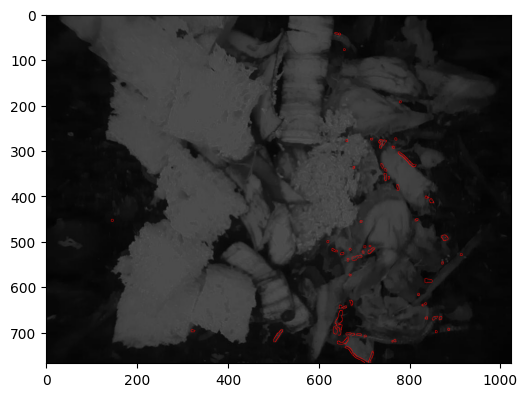

In [87]:
checkImages = [before_before_image, before_image, compare_image, after_image, after_after_image]

image_for_contours = cv2.imread(compare_image)

contours = get_contours(checkImages)

res = cv2.drawContours(image_for_contours, contours, -1, (255, 0, 0), 1)

display(image_for_contours)
sum(cv2.contourArea(contour) for contour in contours)

### Test diff

0.97029179701743


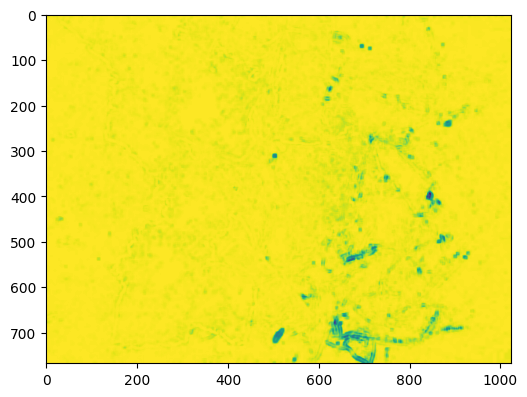

In [88]:
(score, diff) = get_diff(before_image, compare_image)

image_for_diff_contours = cv2.imread(compare_image)

res = cv2.drawContours(image_for_diff_contours, contours, -1, (255, 0, 0), 1)

print(score)
display(diff)

## Collect data from all images

In [89]:
# Initialize background subtractor
backSub = cv2.createBackgroundSubtractorKNN()

contours_list = []  # List to collect all contours

compare_range = 2 

# Loop over the indices of image_files
for i in range(compare_range, len(image_files) - compare_range):
    # Get the 5 images centered around image_files[i]
    images = image_files[i - compare_range:i + (compare_range + 1)]

    # Count the contours in the images
    contours = get_contours(images)
    (score, diff) = get_diff(before_image, compare_image)
    mean_gray = calculate_mean_gray(compare_image)

    # Add the image name, the names of the 4 compared images, and the number of contours to contours_list
    contours_list.append((image_files[i], len(contours), sum(cv2.contourArea(contour) for contour in contours), score, mean_gray))

In [90]:
# Open the CSV file for writing
with open('training_data.csv', 'w', newline='') as csvfile:
    # Create a CSV writer
    writer = csv.writer(csvfile)

    # Write the header
    writer.writerow(['image_name', 'contours_count', 'contours_area', 'diff', 'mean_gray'])

    # Write the data
    for data in contours_list:
        writer.writerow(data)